In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from itertools import product

from plotting_device_resonances import plotting_device_resonances, plotting_device_resonances_iter
from device_order_check import device_order_check
from device_definition import device_definition
from sequential_assignment_v2 import sequential_assignment, device_array_decision, device_heating
from copy import deepcopy

## MRM and CRR resonance definition

In [2]:
tx_bank, rx_bank, laser = device_definition(no_iterations=int(1e4+1))

mrm_resonances_die_wafer_variation = tx_bank["mrm_resonances_die_wafer_variation"]
crr_resonances_die_wafer_variation = rx_bank["crr_resonances_die_wafer_variation"]
ideal_resonance = tx_bank["ideal_resonances"]
laser_frequency = laser["laser_frequency"]

step_sweep = 200

no_mrm_cycling_steps = 4
no_crr_cycling_steps = 6

no_mrm_internal_alignment_steps = 20
no_crr_internal_alignment_steps = 20

debug = 0

### Plotting MRM and CRR resonances

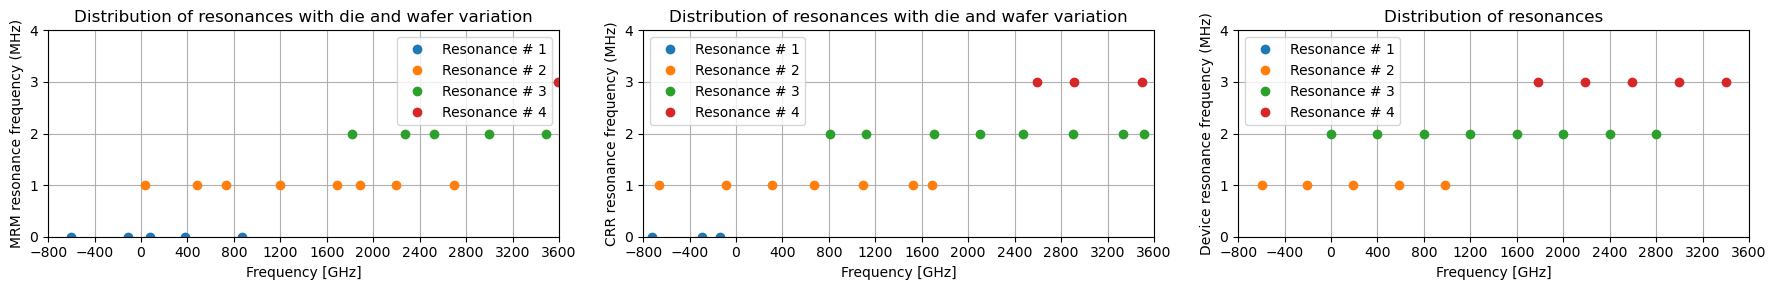

In [3]:
fig = plt.figure(figsize=(18,3))
plt.subplot(131)
plotting_device_resonances(mrm_resonances_die_wafer_variation)
plt.title("Distribution of resonances with die and wafer variation")
plt.ylabel("MRM resonance frequency (MHz)")
plt.subplot(132)
plotting_device_resonances(crr_resonances_die_wafer_variation)
plt.title("Distribution of resonances with die and wafer variation")
plt.ylabel("CRR resonance frequency (MHz)")
plt.subplot(133)
plotting_device_resonances(ideal_resonance)
plt.title("Distribution of resonances")
plt.ylabel("Device resonance frequency (MHz)")
plt.tight_layout()
plt.show()

### Selecting device reference

mrm_assigned:  [0 0 1 1 2 3 3 4 5 5 6 6 7 7]
laser_assigned:  [4 0 1 6 2 7 3 4 0 5 5 1 7 3]
step_assigned:  [-1  1 -1  1 -1 -1  1  1 -1  1 -1  1 -1  1]
mrm_resonances_iter:  [-148.50124254  460.50477718  806.09207755 1005.73319674 1533.35276177
 1918.46517245 2196.50920974 2895.03213084]
mrm_resonances_iter:  [1631.49875746 2246.50477718 2598.09207755 2803.73319674 3337.35276177
 3728.46517245 4012.50920974 4717.03213084]
laser_frequency:  [   0  400  800 1200 1600 2000 2400 2800]
Counts of MRMs vs Laser:  [2 2 1 2 1 2 2 2]


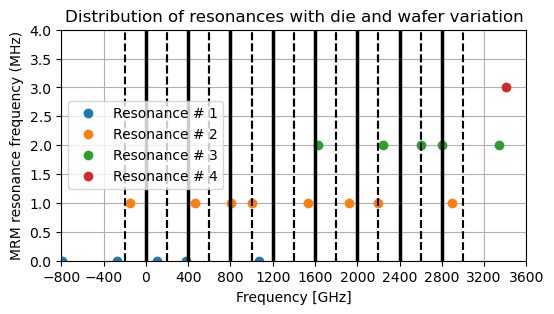

In [4]:
debug = 0
iter_no = 1

mrm_resonances_iter = mrm_resonances_die_wafer_variation[:,:,iter_no]
mrm_assigned, laser_assigned, step_assigned, resonance_assigned = device_order_check(mrm_resonances_iter, laser_frequency)

print("mrm_assigned: ", mrm_assigned)
print("laser_assigned: ", laser_assigned)
print("step_assigned: ", step_assigned)
print("mrm_resonances_iter: ", mrm_resonances_iter[:,2])
print("mrm_resonances_iter: ", mrm_resonances_iter[:,3])
print("laser_frequency: ", laser_frequency)

counts = np.bincount(mrm_assigned)
print("Counts of MRMs vs Laser: ", counts)

fig = plt.figure(figsize=(6,3))
plotting_device_resonances(mrm_resonances_die_wafer_variation, idd_iter = iter_no)
plt.title("Distribution of resonances with die and wafer variation")
plt.ylabel("MRM resonance frequency (MHz)")
for laser_no in range(len(laser_frequency)):
  plt.plot(laser_frequency[laser_no] * np.ones(11), np.linspace(0,6,11), 'k', linewidth=2.5)
  plt.plot(laser_frequency[laser_no] * np.ones(11)+200, np.linspace(0,6,11), 'k', linewidth=1.5, linestyle='dashed')
  plt.plot(laser_frequency[laser_no] * np.ones(11)-200, np.linspace(0,6,11), 'k', linewidth=1.5, linestyle='dashed')
plt.show()

### Sequential Assignment of MRM

In [5]:
count_idx = []

for iter_no in range(mrm_resonances_die_wafer_variation.shape[2]):
  mrm_resonances_iter = mrm_resonances_die_wafer_variation[:,:,iter_no]
  mrm_assigned, laser_assigned, step_assigned, resonance_assigned,  = device_order_check(mrm_resonances_iter, laser_frequency)
  count_idx_temp = device_array_decision(mrm_assigned, mrm_resonances_die_wafer_variation.shape[0], iter_no)
  count_idx.append(count_idx_temp)
  preheat = 0.5
  while count_idx_temp[0][2] < 4:
    mrm_resonances_iter_preheated = device_heating(mrm_resonances_iter, preheat)
    mrm_assigned_preheated, laser_assigned_preheated, step_assigned_preheated, resonance_assigned_preheated  = device_order_check(mrm_resonances_iter_preheated, laser_frequency)
    count_idx_temp = device_array_decision(mrm_assigned_preheated, mrm_resonances_die_wafer_variation.shape[0], iter_no, preheat)
    count_idx[-1] = count_idx_temp
    preheat += 0.5
    
count_idx = np.array(count_idx)
count_idx = count_idx.flatten().reshape(mrm_resonances_die_wafer_variation.shape[2],4)
count_idx.shape

(10001, 4)

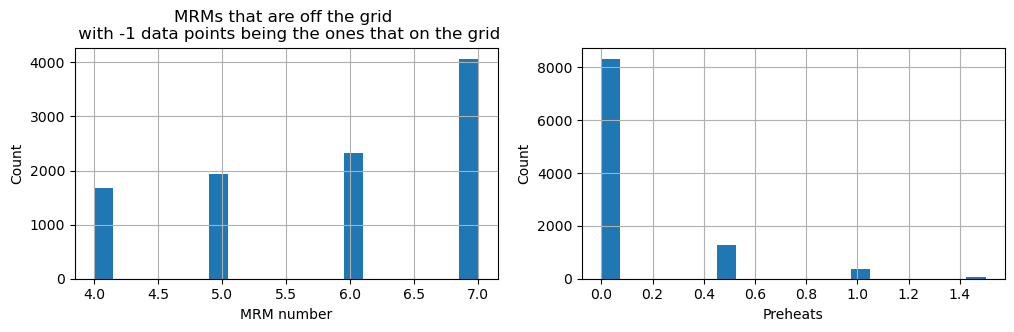

In [6]:
plt.figure(figsize=(12, 3))
plt.subplot(121)
plt.hist(count_idx[:,2].flatten(), rwidth=1.0, bins = 20)
plt.grid(True)
plt.xlabel("MRM number")
plt.ylabel("Count")
plt.title("MRMs that are off the grid \n with -1 data points being the ones that on the grid")
plt.subplot(122)
plt.hist(count_idx[:,1].flatten(), rwidth=1.0, bins = 20)
plt.grid(True)
plt.xlabel("Preheats")
plt.ylabel("Count")
plt.show()

In [7]:
mrm_lock_data = np.zeros((mrm_resonances_die_wafer_variation.shape[0], 4, mrm_resonances_die_wafer_variation.shape[2]))
mrm_sequential_success_metric = []
iter_satisfaction = []

mrm_laser_assigned = []
mrm_sequential_assigned = []
for iter_no in range(mrm_resonances_die_wafer_variation.shape[2]):
  mrm_resonances_iter = mrm_resonances_die_wafer_variation[:,:,iter_no]
  count_idx_iter = count_idx[iter_no, :]
  if count_idx_iter[2] > 3:
    iter_satisfaction.append(iter_no)
    device_assigned, laser_assigned, heat_assigned, resonance_assigned = sequential_assignment(mrm_resonances_iter, laser_frequency, count_idx_iter, tx_bank["mrm_optical_bandwidth"], debug = 0
                                                                                               )
    for laser_assigned_no in range(len(laser_assigned)):
      if laser_assigned[laser_assigned_no] < 0:
        laser_assigned[laser_assigned_no] = laser_assigned[laser_assigned_no] + 7 + 1
    mrm_laser_assigned.append(laser_assigned)
    mrm_lock_data[:, 0, iter_no] = device_assigned
    mrm_lock_data[:, 1, iter_no] = laser_assigned
    mrm_lock_data[:, 2, iter_no] = heat_assigned
    mrm_lock_data[:, 3, iter_no] = resonance_assigned

    mrm_assigned = mrm_lock_data[:, 0, iter_no]
    if mrm_assigned[0] < 7:
      mrm_sequence = deepcopy(mrm_assigned)
      for idx in np.linspace(mrm_assigned[0], 0, int( mrm_assigned[0])+1, dtype=int):
        mrm_sequence[idx] = mrm_assigned[idx] - mrm_assigned[0]
      for idx in np.linspace(7, mrm_assigned[0]+1, 7 - int(mrm_assigned[0]), dtype=int):
        mrm_sequence[idx] = mrm_assigned[idx] - mrm_assigned[0]
    else:
      mrm_sequence = deepcopy(mrm_assigned)
      
    for idx, val in enumerate(mrm_sequence):
      if val < 0:
        mrm_sequence[idx] = val + 7 + 1
    mrm_sequential_assigned.append(mrm_sequence)
    
    if np.min(np.diff(mrm_sequence)) == -1 or np.max(np.diff(mrm_sequence)) == 7:
      mrm_sequential_success_metric.append(iter_no)

print("Successful sequential alignment of MRM to laser wavelengths", len(mrm_sequential_success_metric)/mrm_resonances_die_wafer_variation.shape[2]*100, "%")


Successful sequential alignment of MRM to laser wavelengths 100.0 %


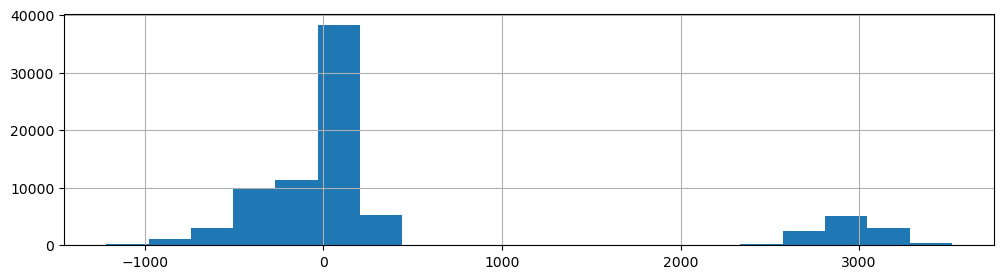

In [8]:
plt.figure(figsize=(12, 3))
plt.hist(mrm_lock_data[:,2].flatten(), rwidth=1.0, bins = 20)
plt.grid(True)
plt.show()